## Test symmetry STEM developed by Joanne Etheridge
Motivation: Use a metric with physical meaning to estimate the quality of tensor SVD denoise, instead of PSNR.
<br>Method: http://arxiv.org/abs/1903.04780 method developed by Joanne to check rotational symmetry in CBED pattern.
<br>Implementation: Joanne used custom C++ code on top of ArrayFire, which is not availabe online. Used Carter's code to convert image into polar coordinates, then use cross-correlation to analysis the symmetry.

In [19]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

from PIL import Image

In [5]:
# path to raw data, denoised data, and ground truth
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/STO/Simulation_noisy_STO_slice_5_1000FPS_fullsize.mat')
raw_data = raw_data['datacube']
truth_data = np.load(path + 'DenoiseInput_fullsize/STO/Simulation_truth_STO_slice_5_1000FPS_fullsize.npy')
denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/STO/Simulation_tensor_STO_slice_5_1000FPS_fullsize.mat')
denoised_data = denoised_data['est_HOOI']

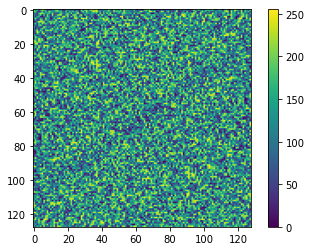

In [18]:
plt.imshow(frame_xcorr)
plt.colorbar()

866.5030606132331


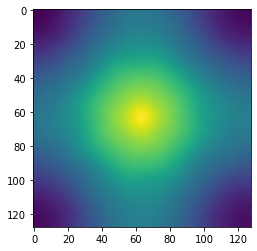

In [40]:
frame = raw_data[10,10,:].reshape(128,128)
frame = frame/np.amax(frame)
rows,cols = frame.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),11,1)
frame_rotate = cv2.warpAffine(frame,M,(cols,rows))
frame_xcorr = scipy.signal.correlate2d(frame,frame_rotate,boundary = 'symm',mode='same')
print(np.amax(frame_xcorr))
plt.imshow(frame_xcorr)

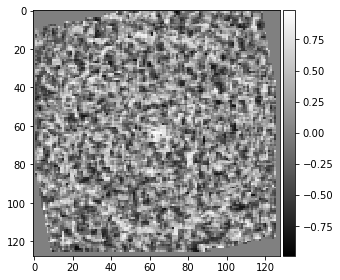

0.9908987839709623


In [41]:
from skimage import io, feature
from scipy import ndimage
import numpy as np

def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

im = frame

im1 = im
sh_row, sh_col = im1.shape
im2 = frame_rotate

# Registration of the two images
# translation = feature.register_translation(im1, im2, upsample_factor=10)[0]
# im2_register = ndimage.shift(im2, translation)

d = 1

correlation = np.zeros_like(im1)

for i in range(d, sh_row - (d + 1)):
    for j in range(d, sh_col - (d + 1)):
        correlation[i, j] = correlation_coefficient(im1[i - d: i + d + 1,
                                                        j - d: j + d + 1],
                                                    im2[i - d: i + d + 1,
                                                        j - d: j + d + 1])

io.imshow(correlation, cmap='gray')
io.show()
print(np.amax(correlation))

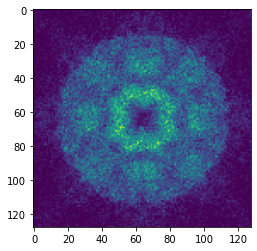

In [36]:
plt.imshow(im2)

In [4]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle
from scipy.interpolate import RectBivariateSpline

def convert (img, size, center, correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 360
    r_inital = 0
    r_final =150
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,1))
#     initial_x, initial_y = create_grid(range(1,size[0]+1),range(1,size[1]+1))
#     initial_y, initial_x = range(1, 513), range(1, 513)
    initial_y, initial_x = range(1, size[0]+1), range(1, size[1]+1)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
#     inten = np.reshape(img,size[0]*size[1])
#     polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    inten = img
    spline = RectBivariateSpline(initial_x, initial_y,inten,kx=1,ky=1)
    polar_img = spline.ev(final_x,final_y)
    
    polar_img = np.reshape(polar_img, [r_final, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return
